In [1]:
import numpy as np
import json
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable

In [7]:
np.random.seed(0)
NUM_BODY_PARTS = 13
TOTAL_FRAMES = 250
BATCH_SIZE = 1
# We have 250 frames. We are going to going to take the 17 body parts, 
# and turn it into 13 (remove eyes and ears). Then 13x2 (13 body parts, 2 vectors), gets shaped to
# 26. We then take that 26, and convert it into a 250 x 26, each frame shows a body part.
def from_motion_to_numpy_vector(motion):
    # For now, we only take the first person. Later we can maybe try to feed in all people, or do batches of two
    motion_vector = np.zeros((250, NUM_BODY_PARTS * 2))
    if len(motion) < 250:
        print("We need 250 frames.")
    for i, frame in enumerate(motion):
        if len(frame) > 0 and i < TOTAL_FRAMES:
            current_frame_data = frame
            person0 = current_frame_data[0][1:]
            current_frame_vector = np.zeros((NUM_BODY_PARTS, 2))
            current_body_part_idx = 0
            for body_part_data in person0:
                body_part = body_part_data[0]
                if body_part not in ['left_eye', 'left_ear', 'right_eye', 'right_ear']:
                    current_frame_vector[current_body_part_idx] = body_part_data[1]
                    current_body_part_idx = current_body_part_idx + 1
            motion_vector[i] = current_frame_vector.reshape(NUM_BODY_PARTS * 2)
    return motion_vector

def from_numpy_vector_to_motion_coordinates(motion_vector):
    # Reshape so each element in array is an a NUM_BODY_PARTS x 2 array that has coordinates
    return motion_vector.reshape(TOTAL_FRAMES, NUM_BODY_PARTS, 2)

class LetsDanceDataset(torch.utils.data.Dataset):
    categories_hash = {'tango': 0, 'break': 1, 'swing': 2,'quickstep': 3,
                  'foxtrot': 4,'pasodoble': 5,'tap': 6,'samba': 7,'flamenco': 8,
                  'ballet': 9,'rumba': 10,'waltz': 11,'cha': 12,'latin': 13,
                  'square': 14,'jive': 15}
    
    def __init__(self, root_dir):
        super().__init__()
        self.root_dir = root_dir
        category = 'latin'

        # For this first test, we are just using Latin dances
        with open('./dance-frame-list.json') as f:
            frames_index = json.load(f)
                    
        latin_dances = list(filter(lambda dance: dance[0] == 'latin' and dance[2] >= TOTAL_FRAMES, frames_index))
        
        self.data = np.zeros((len(latin_dances), TOTAL_FRAMES, NUM_BODY_PARTS * 2))
        self.metadata = latin_dances
        
        for i, dance in enumerate(latin_dances):
            [category, dance_id, frames] = dance
            current_frame_path = "{}{}/{}.json".format(root_dir, category, dance_id)
            with open(current_frame_path) as f:
                motion = json.load(f)
            self.data[i] = from_motion_to_numpy_vector(motion)
            
        f.close()
        
    def __len__(self):
        return len(self.data)
    
    def getitem_metadata(self, index):
        return self.metadata[index]
    
    def __getitem__(self, index):
        data = self.data[index]
        with_batch_size = np.zeros((1, data.shape[0], data.shape[1]))
        with_batch_size[0] = data
        in_frames = with_batch_size
        out_frames = np.zeros_like(in_frames)
        out_frames[:-1] = in_frames[1:]
        out_frames[-1] = in_frames[0]
        return torch.from_numpy(in_frames), torch.from_numpy(out_frames)
    
dataloader = LetsDanceDataset('../densepose/full/')

# Examples of the data

In [8]:
dataloader[1][0].shape
# in_frames = motion[:num_batches * BATCH_SIZE * 250]
# TODO
# Bounding box idea, since the coordinates are all over the place, we should bound it to a certain box
# try to clean data

torch.Size([1, 250, 26])

In [4]:
# internally it works kinda like this
current_frame_path = "../densepose/full/latin/QmL0QYsctV0_030.json"
with open(current_frame_path) as f:
    motion = json.load(f)
        
# for now, just return person 1 on the first frame, 
# just to see if it generates any stick figures
# motion = np.array([pose_to_numpy(frame)[0].reshape(34) for frame in motion if len(frame) > 0])

In [5]:
person0 = motion[0]
person0

[['person0',
  ['nose', [1051.7425537109375, 74.26245880126953]],
  ['left_eye', [1049.74853515625, 56.2840690612793]],
  ['right_eye', [1045.760498046875, 56.2840690612793]],
  ['left_ear', [1007.874755859375, 54.286468505859375]],
  ['right_ear', [1011.8627319335938, 53.28767013549805]],
  ['left_shoulder', [1033.796630859375, 122.204833984375]],
  ['right_shoulder', [979.9589233398438, 107.22283935546875]],
  ['left_elbow', [1061.7125244140625, 203.1075897216797]],
  ['right_elbow', [1025.8206787109375, 195.1171875]],
  ['left_wrist', [1098.601318359375, 213.0955810546875]],
  ['right_wrist', [1099.5982666015625, 209.1003875732422]],
  ['left_hip', [1032.7996826171875, 318.96832275390625]],
  ['right_hip', [992.9197998046875, 317.9695129394531]],
  ['left_knee', [1087.6343994140625, 465.7918395996094]],
  ['right_knee', [1057.7244873046875, 466.7906494140625]],
  ['left_ankle', [1047.7545166015625, 649.5709228515625]],
  ['right_ankle', [1022.8296508789062, 663.5541381835938]]],
 ['

In [6]:
a = np.zeros((12, 2))
a[0] = [1,2]
a.reshape(24)

array([1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

# Running

In [10]:
def draw_points(points):
    plt.xlim(0, 1980)
    plt.ylim(-1000, 0)
    reshaped = points.reshape(NUM_BODY_PARTS, 2)
    x = reshaped[:,0]
    y = reshaped[:,1]
    plt.scatter(x, -y, s=10, marker='.',)
    plt.show()

In [11]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [127]:
# input_dim = 26
# hidden_dim = 10
# n_layers = 2
# lstm_layer = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
# batch_size = 1
# seq_len = 10

# inp = torch.randn(batch_size, seq_len, input_dim)
# hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
# cell_state = torch.randn(n_layers, batch_size, hidden_dim)
# hidden = (hidden_state, cell_state)
# out, hidden = lstm_layer(inp, hidden)
# print("Output shape: ", out.shape)
# print("Hidden: ", hidden)

Output shape:  torch.Size([1, 10, 10])
Hidden:  (tensor([[[ 0.4691,  0.3007,  0.1901,  0.0947, -0.2166, -0.0910,  0.0847,
           0.2070, -0.0761, -0.0679]],

        [[ 0.0083, -0.1061,  0.2938, -0.1118, -0.0007, -0.0309, -0.3493,
          -0.0033,  0.2563, -0.1784]]], grad_fn=<StackBackward>), tensor([[[ 1.0399,  0.3968,  0.2334,  0.3971, -0.2472, -0.2513,  0.1130,
           0.3354, -0.1005, -0.3186]],

        [[ 0.0150, -0.2194,  0.5644, -0.2261, -0.0015, -0.0572, -0.7213,
          -0.0072,  0.5234, -0.3800]]], grad_fn=<StackBackward>))


<function next>

In [35]:
class DanceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(DanceModel, self).__init__()

        # Defining some parameters
        self.hidden_dim = 500
        self.n_layers = 15

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, self.hidden_dim, self.n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(self.hidden_dim, output_size)
    
    def forward(self, x, hidden):
        batch_size = x.size(0) # i am confused by batch size
        x = x.float()
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = (
            torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
            torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

In [36]:
body_part_vector_size = NUM_BODY_PARTS * 2
model = DanceModel(body_part_vector_size, body_part_vector_size)
model.to(device)

lr=0.005
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [39]:
from torch.utils.tensorboard import SummaryWriter

experiment_name = 'experiments/{}/lr_{}'.format('rnn_test1',lr)

os.makedirs(experiment_name, exist_ok=True)

writer = SummaryWriter(log_dir=experiment_name)

In [37]:
epochs = 20
print_every = 1000
clip = 5
counter = 0
valid_loss_min = np.Inf
batch_size = 1

model.zero_grad()
optimizer.zero_grad()
model.train()
for epoch in range(epochs+1):
    (h, c) = model.init_hidden(BATCH_SIZE)
    for step, (inputs, expected) in enumerate(dataloader):
        counter += 1
        inputs = inputs.to(device)
        expected = inputs.to(device)
        model.zero_grad()
        
        # Forward pass
        h.detach_()
        c.detach_()
        output, (h, c) = model(inputs.float(), (h,c))
        loss = criterion(output.double(), expected.double())
        
        # Backward and optimize
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        optimizer.zero_grad()
        
        print('Epoch [{}/{}] Step [{}/{}] Loss {:.4f}'.format(epoch, epochs, step, len(dataloader), loss))

Epoch [0/20] Step [0/67] Loss 336839.0659
Epoch [0/20] Step [1/67] Loss 370929.6671
Epoch [0/20] Step [2/67] Loss 366531.7084
Epoch [0/20] Step [3/67] Loss 326088.1735
Epoch [0/20] Step [4/67] Loss 314085.8424
Epoch [0/20] Step [5/67] Loss 396395.6989
Epoch [0/20] Step [6/67] Loss 439895.4363
Epoch [0/20] Step [7/67] Loss 426482.7389
Epoch [0/20] Step [8/67] Loss 622114.6107
Epoch [0/20] Step [9/67] Loss 650408.1282
Epoch [0/20] Step [10/67] Loss 381493.1081
Epoch [0/20] Step [11/67] Loss 240450.0151
Epoch [0/20] Step [12/67] Loss 615656.1330
Epoch [0/20] Step [13/67] Loss 440793.6029
Epoch [0/20] Step [14/67] Loss 619011.9182
Epoch [0/20] Step [15/67] Loss 203690.0871
Epoch [0/20] Step [16/67] Loss 459148.0891
Epoch [0/20] Step [17/67] Loss 187177.9764
Epoch [0/20] Step [18/67] Loss 568982.7875
Epoch [0/20] Step [19/67] Loss 313267.9685
Epoch [0/20] Step [20/67] Loss 310742.2918
Epoch [0/20] Step [21/67] Loss 328269.8259
Epoch [0/20] Step [22/67] Loss 231663.1119
Epoch [0/20] Step [23

Epoch [2/20] Step [58/67] Loss 273049.3223
Epoch [2/20] Step [59/67] Loss 222922.6422
Epoch [2/20] Step [60/67] Loss 164911.0106
Epoch [2/20] Step [61/67] Loss 310052.8007
Epoch [2/20] Step [62/67] Loss 297732.0075
Epoch [2/20] Step [63/67] Loss 244313.7010
Epoch [2/20] Step [64/67] Loss 79299.7464
Epoch [2/20] Step [65/67] Loss 50178.9488
Epoch [2/20] Step [66/67] Loss 107577.3899
Epoch [3/20] Step [0/67] Loss 144438.5620
Epoch [3/20] Step [1/67] Loss 157082.2542
Epoch [3/20] Step [2/67] Loss 146243.6891
Epoch [3/20] Step [3/67] Loss 118645.3903
Epoch [3/20] Step [4/67] Loss 114469.2041
Epoch [3/20] Step [5/67] Loss 163186.3729
Epoch [3/20] Step [6/67] Loss 205933.8186
Epoch [3/20] Step [7/67] Loss 210229.3886
Epoch [3/20] Step [8/67] Loss 311602.8020
Epoch [3/20] Step [9/67] Loss 330053.1798
Epoch [3/20] Step [10/67] Loss 156489.4917
Epoch [3/20] Step [11/67] Loss 88971.3622
Epoch [3/20] Step [12/67] Loss 316695.1697
Epoch [3/20] Step [13/67] Loss 180461.8421
Epoch [3/20] Step [14/67

Epoch [5/20] Step [51/67] Loss 26150.9438
Epoch [5/20] Step [52/67] Loss 177869.1689
Epoch [5/20] Step [53/67] Loss 179464.9785
Epoch [5/20] Step [54/67] Loss 205342.4151
Epoch [5/20] Step [55/67] Loss 7524.7610
Epoch [5/20] Step [56/67] Loss 67899.2743
Epoch [5/20] Step [57/67] Loss 25346.1387
Epoch [5/20] Step [58/67] Loss 102216.4871
Epoch [5/20] Step [59/67] Loss 83920.4913
Epoch [5/20] Step [60/67] Loss 45372.9263
Epoch [5/20] Step [61/67] Loss 138234.6300
Epoch [5/20] Step [62/67] Loss 117484.4644
Epoch [5/20] Step [63/67] Loss 84561.3366
Epoch [5/20] Step [64/67] Loss 16085.1511
Epoch [5/20] Step [65/67] Loss 8744.2353
Epoch [5/20] Step [66/67] Loss 34391.9267
Epoch [6/20] Step [0/67] Loss 59682.1611
Epoch [6/20] Step [1/67] Loss 70902.7574
Epoch [6/20] Step [2/67] Loss 40879.1737
Epoch [6/20] Step [3/67] Loss 26661.0826
Epoch [6/20] Step [4/67] Loss 27602.5128
Epoch [6/20] Step [5/67] Loss 49377.2338
Epoch [6/20] Step [6/67] Loss 79331.0838
Epoch [6/20] Step [7/67] Loss 104626.

Epoch [8/20] Step [46/67] Loss 17492.2617
Epoch [8/20] Step [47/67] Loss 18893.3620
Epoch [8/20] Step [48/67] Loss 29058.0684
Epoch [8/20] Step [49/67] Loss 195153.8573
Epoch [8/20] Step [50/67] Loss 15219.6267
Epoch [8/20] Step [51/67] Loss 30462.3084
Epoch [8/20] Step [52/67] Loss 98964.0071
Epoch [8/20] Step [53/67] Loss 127133.8760
Epoch [8/20] Step [54/67] Loss 125674.0062
Epoch [8/20] Step [55/67] Loss 8427.6209
Epoch [8/20] Step [56/67] Loss 93636.5080
Epoch [8/20] Step [57/67] Loss 7842.2990
Epoch [8/20] Step [58/67] Loss 53701.7545
Epoch [8/20] Step [59/67] Loss 47790.3253
Epoch [8/20] Step [60/67] Loss 23251.9911
Epoch [8/20] Step [61/67] Loss 89556.9346
Epoch [8/20] Step [62/67] Loss 58302.8720
Epoch [8/20] Step [63/67] Loss 36859.4297
Epoch [8/20] Step [64/67] Loss 16118.3861
Epoch [8/20] Step [65/67] Loss 19509.1752
Epoch [8/20] Step [66/67] Loss 30080.2274
Epoch [9/20] Step [0/67] Loss 45548.6555
Epoch [9/20] Step [1/67] Loss 62415.4302
Epoch [9/20] Step [2/67] Loss 18630

Epoch [11/20] Step [38/67] Loss 47771.9672
Epoch [11/20] Step [39/67] Loss 80948.0999
Epoch [11/20] Step [40/67] Loss 8215.5587
Epoch [11/20] Step [41/67] Loss 34563.2116
Epoch [11/20] Step [42/67] Loss 27732.2720
Epoch [11/20] Step [43/67] Loss 8483.2644
Epoch [11/20] Step [44/67] Loss 25573.5369
Epoch [11/20] Step [45/67] Loss 119781.4693
Epoch [11/20] Step [46/67] Loss 24369.6482
Epoch [11/20] Step [47/67] Loss 20663.9279
Epoch [11/20] Step [48/67] Loss 18947.9500
Epoch [11/20] Step [49/67] Loss 167211.4331
Epoch [11/20] Step [50/67] Loss 21072.7154
Epoch [11/20] Step [51/67] Loss 38245.9680
Epoch [11/20] Step [52/67] Loss 77221.8029
Epoch [11/20] Step [53/67] Loss 114736.8170
Epoch [11/20] Step [54/67] Loss 103515.9412
Epoch [11/20] Step [55/67] Loss 14715.8979
Epoch [11/20] Step [56/67] Loss 108720.0395
Epoch [11/20] Step [57/67] Loss 7351.3140
Epoch [11/20] Step [58/67] Loss 42297.3293
Epoch [11/20] Step [59/67] Loss 40770.2601
Epoch [11/20] Step [60/67] Loss 21268.2590
Epoch [11

Epoch [14/20] Step [28/67] Loss 29454.7582
Epoch [14/20] Step [29/67] Loss 95019.0179
Epoch [14/20] Step [30/67] Loss 110551.5977
Epoch [14/20] Step [31/67] Loss 55369.5694
Epoch [14/20] Step [32/67] Loss 36721.3518
Epoch [14/20] Step [33/67] Loss 17497.1263
Epoch [14/20] Step [34/67] Loss 36004.6631
Epoch [14/20] Step [35/67] Loss 24759.8479
Epoch [14/20] Step [36/67] Loss 78546.1928
Epoch [14/20] Step [37/67] Loss 51436.4856
Epoch [14/20] Step [38/67] Loss 45980.5382
Epoch [14/20] Step [39/67] Loss 73195.8533
Epoch [14/20] Step [40/67] Loss 8346.2779
Epoch [14/20] Step [41/67] Loss 29907.2051
Epoch [14/20] Step [42/67] Loss 25528.5200
Epoch [14/20] Step [43/67] Loss 8404.2293
Epoch [14/20] Step [44/67] Loss 29666.0372
Epoch [14/20] Step [45/67] Loss 110408.8945
Epoch [14/20] Step [46/67] Loss 27625.6861
Epoch [14/20] Step [47/67] Loss 22135.7139
Epoch [14/20] Step [48/67] Loss 16180.1587
Epoch [14/20] Step [49/67] Loss 157855.4889
Epoch [14/20] Step [50/67] Loss 23947.8223
Epoch [14/

Epoch [17/20] Step [18/67] Loss 47997.7555
Epoch [17/20] Step [19/67] Loss 33292.4885
Epoch [17/20] Step [20/67] Loss 43881.0851
Epoch [17/20] Step [21/67] Loss 32781.7665
Epoch [17/20] Step [22/67] Loss 26939.2808
Epoch [17/20] Step [23/67] Loss 95154.9793
Epoch [17/20] Step [24/67] Loss 72477.6244
Epoch [17/20] Step [25/67] Loss 14356.6982
Epoch [17/20] Step [26/67] Loss 44275.2969
Epoch [17/20] Step [27/67] Loss 111711.0695
Epoch [17/20] Step [28/67] Loss 30211.6533
Epoch [17/20] Step [29/67] Loss 92061.9401
Epoch [17/20] Step [30/67] Loss 110046.8082
Epoch [17/20] Step [31/67] Loss 52998.8785
Epoch [17/20] Step [32/67] Loss 34979.4689
Epoch [17/20] Step [33/67] Loss 17235.2538
Epoch [17/20] Step [34/67] Loss 34347.1233
Epoch [17/20] Step [35/67] Loss 26331.9506
Epoch [17/20] Step [36/67] Loss 75934.1803
Epoch [17/20] Step [37/67] Loss 53782.0060
Epoch [17/20] Step [38/67] Loss 45425.3890
Epoch [17/20] Step [39/67] Loss 70451.8425
Epoch [17/20] Step [40/67] Loss 8459.6995
Epoch [17/

Epoch [20/20] Step [8/67] Loss 57465.4027
Epoch [20/20] Step [9/67] Loss 62229.7081
Epoch [20/20] Step [10/67] Loss 27723.2620
Epoch [20/20] Step [11/67] Loss 72293.9385
Epoch [20/20] Step [12/67] Loss 99246.9312
Epoch [20/20] Step [13/67] Loss 50245.7345
Epoch [20/20] Step [14/67] Loss 50061.2822
Epoch [20/20] Step [15/67] Loss 40671.5978
Epoch [20/20] Step [16/67] Loss 26274.2966
Epoch [20/20] Step [17/67] Loss 30425.8220
Epoch [20/20] Step [18/67] Loss 47304.5062
Epoch [20/20] Step [19/67] Loss 33509.9307
Epoch [20/20] Step [20/67] Loss 44135.9267
Epoch [20/20] Step [21/67] Loss 32929.5231
Epoch [20/20] Step [22/67] Loss 27443.0810
Epoch [20/20] Step [23/67] Loss 95822.7164
Epoch [20/20] Step [24/67] Loss 73150.3546
Epoch [20/20] Step [25/67] Loss 14577.0792
Epoch [20/20] Step [26/67] Loss 44971.5715
Epoch [20/20] Step [27/67] Loss 110625.0994
Epoch [20/20] Step [28/67] Loss 30501.6083
Epoch [20/20] Step [29/67] Loss 90945.2300
Epoch [20/20] Step [30/67] Loss 109865.0828
Epoch [20/2

In [17]:
frames = dataloader[0][0]
frames.shape

torch.Size([1, 250, 26])

In [43]:
model.eval()
frame1 = dataloader[45][0][0].reshape(1, 250, 26)
stath, statc = model.init_hidden(1)
stath.to(device)
statc.to(device)
output, (shh, scc) = model(frame1.to(device), (stath, statc))

In [44]:
v = from_numpy_vector_to_motion_coordinates(output[0]).detach().cpu().numpy()

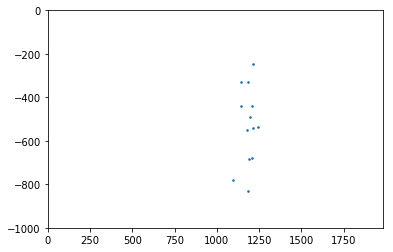

In [68]:
draw_points(from_numpy_vector_to_motion_coordinates(frame1[0])[58])